In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde
from datetime import timedelta

sns.set_theme(style="whitegrid")
sns.set_palette("viridis")
%matplotlib inline

In [21]:
# Load data ensuring date parsing
df = pd.read_csv('ExamplePats.csv', parse_dates=['eksd'])
df.columns = ['pnr', 'eksd', 'perday', 'ATC', 'dur_original']
df['eksd'] = pd.to_datetime(df['eksd'])

# Display sample data
print("Initial Data:")
display(df.head().style.format({
    'eksd': lambda x: x.strftime('%Y-%m-%d'),
    'pnr': '{:02d}'.format
}).set_caption("Sample Prescription Data"))

Initial Data:


,pnr,eksd,perday,ATC,dur_original
0,01,2033-04-26,4,medA,50
1,01,2033-07-04,4,medB,30
2,01,2033-08-03,4,medB,30
3,01,2033-08-17,4,medB,30
4,01,2033-10-13,4,medB,30


In [22]:
def full_analysis(medication, data):
    # Filter medication-specific data
    med_df = data[data['ATC'] == medication].copy()
    
    # Ensure sorting and lag calculation are correct
    med_df = med_df.sort_values(['pnr', 'eksd'])
    med_df['prev_eksd'] = med_df.groupby('pnr')['eksd'].shift(1)
    med_df = med_df.dropna(subset=['prev_eksd'])
    med_df['event_interval'] = (med_df['eksd'] - med_df['prev_eksd']).dt.days

    # Random sampling
    sampled_df = med_df.groupby('pnr', group_keys=False).apply(
        lambda x: x.sample(1, random_state=42)
    ).reset_index(drop=True)

    # ECDF calculation
    intervals = sampled_df['event_interval'].values
    ecdf = ECDF(intervals)
    ecdf_df = pd.DataFrame({'days': ecdf.x, 'probability': ecdf.y})
    ecdf_80 = ecdf_df[ecdf_df['probability'] <= 0.8]

    # Generate visualizations
    generate_visualizations(sampled_df, ecdf_df, ecdf_80, intervals, medication)
    
    return sampled_df, med_df

In [23]:
def generate_visualizations(sampled_df, ecdf_df, ecdf_80, intervals, medication):
    fig = plt.figure(figsize=(15, 12))

    # 80% ECDF
    plt.subplot(3, 2, 1)
    plt.plot(ecdf_80['days'], ecdf_80['probability'])
    plt.title(f'80% ECDF - {medication}')
    plt.xlabel('Days Between Prescriptions')
    plt.ylabel('Cumulative Probability')

    # 100% ECDF
    plt.subplot(3, 2, 2)
    plt.plot(ecdf_df['days'], ecdf_df['probability'])
    plt.title(f'100% ECDF - {medication}')
    plt.xlabel('Days Between Prescriptions')
    plt.ylabel('Cumulative Probability')

    # Prescription Frequency Distribution
    plt.subplot(3, 2, 3)
    prescription_counts = sampled_df['pnr'].value_counts()
    sns.barplot(x=prescription_counts.values, y=prescription_counts.index.astype(str), orient='h')
    plt.title(f'Prescription Frequency - {medication}')
    plt.xlabel('Number of Prescriptions')
    plt.ylabel('Patient ID')

    # Log-Transformed Density Plot
    plt.subplot(3, 2, 4)
    log_intervals = np.log1p(intervals)  # use log1p
    density = gaussian_kde(log_intervals)
    x = np.linspace(log_intervals.min(), log_intervals.max(), 1000)
    plt.plot(x, density(x))
    plt.title(f'Log Interval Density - {medication}')
    plt.xlabel('Log(Days Between Prescriptions)')
    plt.ylabel('Probability Density')

    # Silhouette Analysis
    plt.subplot(3, 2, 5)
    range_clusters = range(2, min(10, len(np.unique(sampled_df['pnr'])))) # Ensure less than unique patient IDs
    if len(range_clusters) > 1:
        silhouette_scores = [silhouette_score(np.log1p(intervals).reshape(-1, 1), 
                                             KMeans(n_clusters=i, random_state=42).fit_predict(np.log1p(intervals).reshape(-1, 1)))
                             for i in range_clusters]
        plt.plot(range_clusters, silhouette_scores, 'bo-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.title(f'Cluster Optimization - {medication}')
    else:
        plt.text(0.5, 0.5, 'Not enough data for clustering', ha='center', va='center')
    
    # Cluster Distribution
    plt.subplot(3, 2, 6)
    if len(range_clusters) > 1:
        optimal_clusters = range_clusters[np.argmax(silhouette_scores)]
        kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
        sampled_df['cluster'] = kmeans.fit_predict(np.log1p(intervals).reshape(-1, 1))
        sns.histplot(data=sampled_df, x='event_interval', hue='cluster', kde=True)
        plt.title(f'Adherence Clusters - {medication}')
        plt.xlabel('Days Between Prescriptions')
    else:
        plt.text(0.5, 0.5, 'Not enough data for clustering', ha='center', va='center')

    plt.tight_layout()
    plt.show()

    # Boxplots
    validate_adherence(sampled_df, medication)

In [24]:
def validate_adherence(data, medication):
    # Ensure prescription sequence is calculated correctly
    analysis_df = data.copy()
    analysis_df['prescription_seq'] = analysis_df.groupby('pnr').cumcount() + 1
    analysis_df = analysis_df[analysis_df['prescription_seq'] >= 2]

    # Calculate median durations
    medians = analysis_df.groupby('pnr')['event_interval'].median().reset_index()
    
    if not analysis_df.empty:
        # Create boxplot
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='prescription_seq', y='event_interval', data=analysis_df)
        plt.axhline(y=medians['event_interval'].median(), color='r', linestyle='--', label='Median Duration')
        plt.title(f'Adherence Validation - {medication}')
        plt.xlabel('Prescription Sequence Number')
        plt.ylabel('Days Between Prescriptions')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()
    
        # Cluster metrics table
        cluster_metrics = analysis_df.groupby('cluster').agg(
            Median_Days=('event_interval', 'median'),
            Patient_Count=('pnr', 'nunique')
        ).reset_index().sort_values('Median_Days')

        print(f"\nCluster Characteristics for {medication}:")
        display(cluster_metrics.style.format({'Median_Days': '{:.1f}'}).set_caption(f"{medication} Cluster Metrics"))
    else:
        print(f"Not enough data for Adherence Validation for {medication}")

/var/folders/0c/v2nhsh9s293121gc7bkkm4p00000gn/T/ipykernel_8888/4079416140.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = med_df.groupby('pnr', group_keys=False).apply(


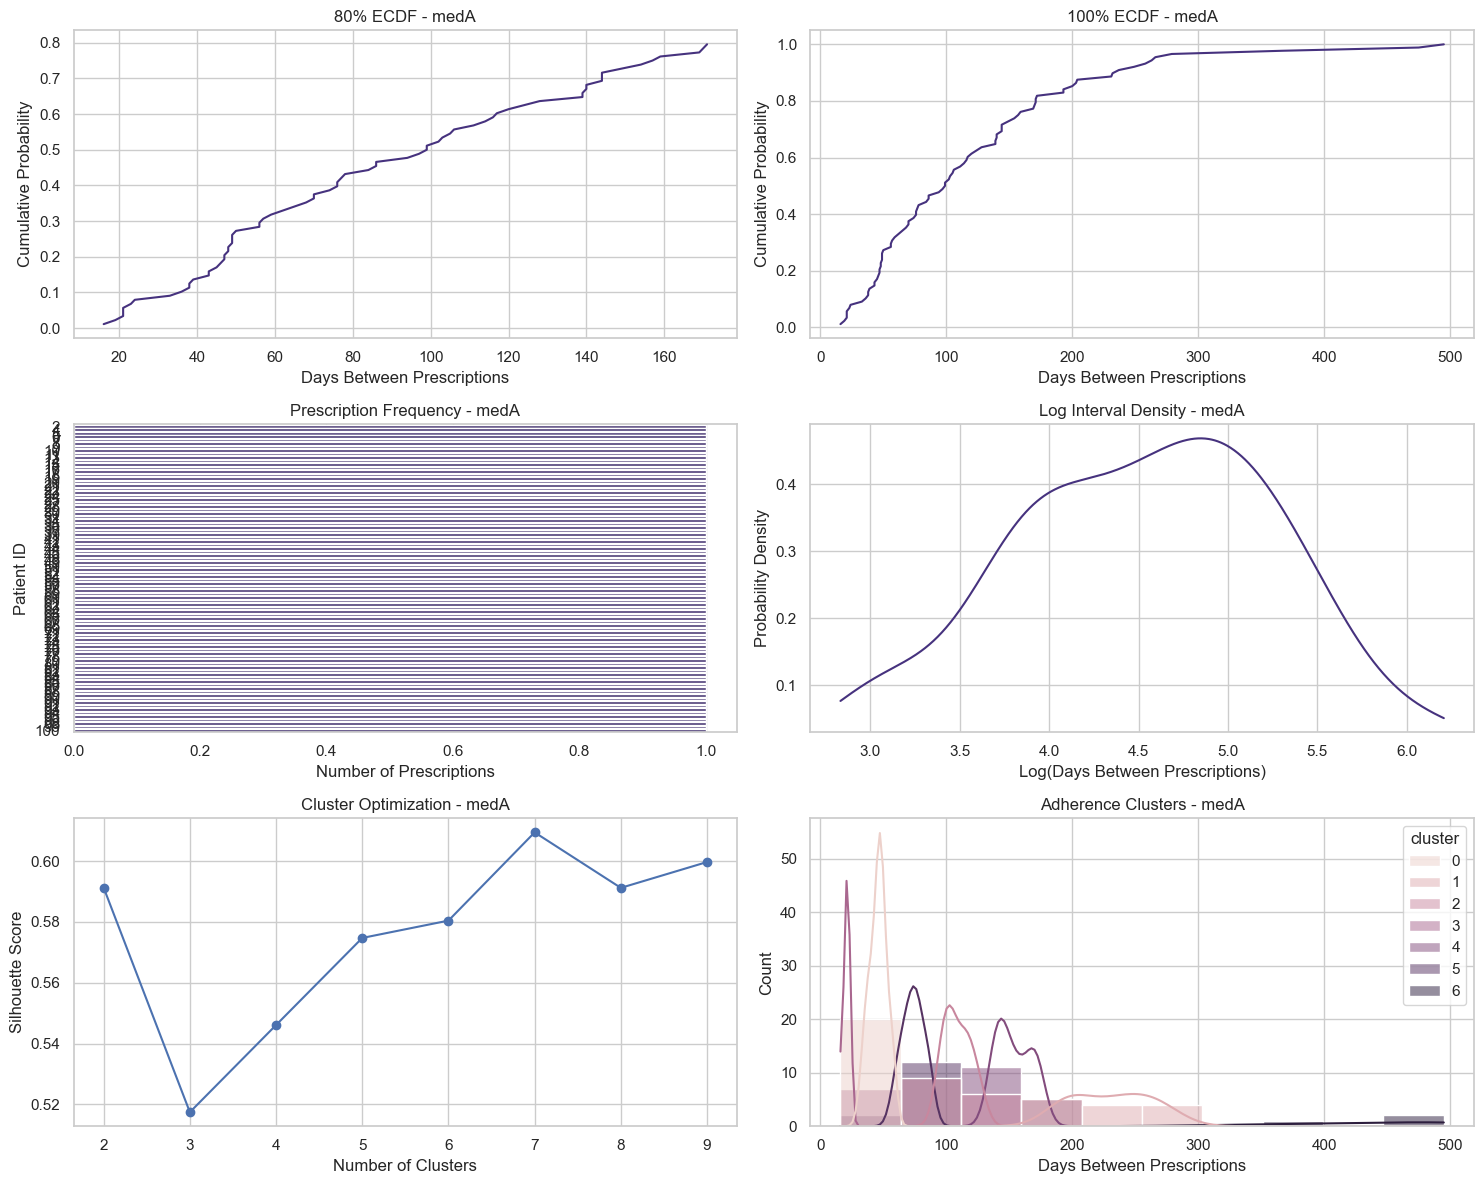

Not enough data for Adherence Validation for medA


/var/folders/0c/v2nhsh9s293121gc7bkkm4p00000gn/T/ipykernel_8888/4079416140.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = med_df.groupby('pnr', group_keys=False).apply(


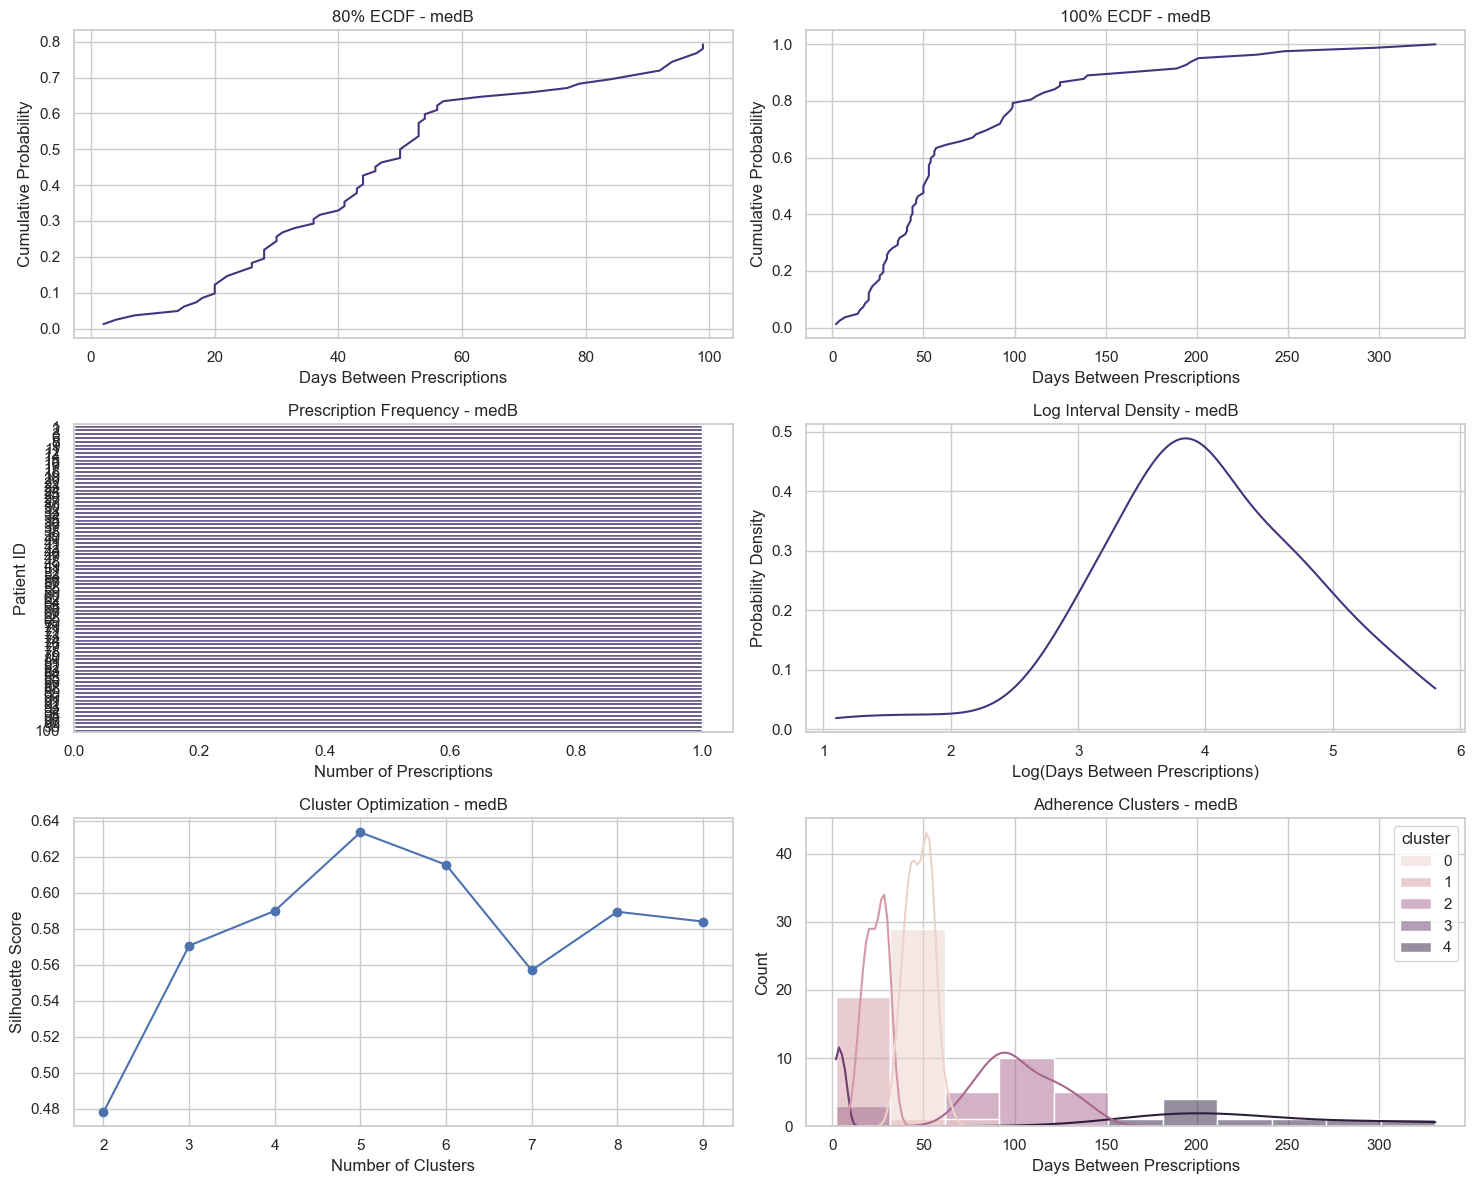

Not enough data for Adherence Validation for medB


In [25]:
if __name__ == "__main__":
    medications = ['medA', 'medB']
    
    for med in medications:
        sampled_df, med_df = full_analysis(med, df)